In [1]:
import os
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir,os.pardir))
os.chdir(parent_dir)

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from vae_earlystopping import EarlyStopping
from model.m26odel_bce import MultiDecoderCondVAE
from loss.l26oss_bce_1 import integrated_loss_fn

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
train_loader = torch.load('torch/pre_retrain_loader.pt',weights_only= False)
val_loader = torch.load('torch/pre_reval_loader.pt',weights_only = False)
test_loader = torch.load('torch/pre_retest_loader.pt',weights_only=False)

In [5]:
x_sample,c_sample = next(iter(train_loader))
x_dim = x_sample.shape[1]
c_dim = c_sample.shape[1]

In [6]:
model = MultiDecoderCondVAE(x_dim=x_dim,c_dim=c_dim,z_dim = 8 ).to(device)
early_stopping = EarlyStopping(patience = 40, min_delta = 1e-9)
optimizer = optim.Adam(model.parameters(),lr = 1e-3, weight_decay = 1e-5)

In [7]:
history = {'train_loss':[],'train_bce':[],'train_kl':[],'val_loss':[],'val_bce':[],'val_kl':[]}
epochs = 400

### train_val 시작 (beta = 1.0, gamma = 1.0)

In [8]:
for epoch in range(1,1+epochs):
    model.train()
    t_loss, t_bce, t_kl = 0,0,0
    for x,c in train_loader:
        x = x.to(device)
        c = c.to(device)
        optimizer.zero_grad()
        bce_logit, prob_mask, binary_out, mu,logvar = model(x,c)
        loss_dict= integrated_loss_fn(bce_logit,x,mu,logvar)
        loss_dict['loss'].backward()
        optimizer.step()
        t_loss +=loss_dict['loss'].item()
        t_bce += loss_dict['bce_loss'].item()
        t_kl += loss_dict['kl_loss'].item()

    model.eval()
    v_loss,v_bce,v_kl = 0,0,0
    with torch.no_grad():
        for v_x,v_c in val_loader:
            v_x,v_c = v_x.to(device),v_c.to(device)
            v_bce_logit,v_prob_mask,v_binary_out, v_mu, v_logvar = model(v_x,v_c)
            v_loss_dict = integrated_loss_fn(v_bce_logit,v_x, v_mu, v_logvar)
            v_loss += v_loss_dict['loss'].item()
            v_bce += v_loss_dict['bce_loss'].item()
            v_kl += v_loss_dict['kl_loss'].item()

    avg_train_loss = t_loss/len(train_loader)
    avg_val_loss = v_loss/len(val_loader)
    history['train_loss'].append(t_loss/len(train_loader))
    history['train_bce'].append(t_bce/len(train_loader))
    history['train_kl'].append(t_kl/len(train_loader))
    history['val_loss'].append(v_loss/len(val_loader))
    history['val_bce'].append(v_bce/len(val_loader))
    history['val_kl'].append(v_kl/len(val_loader))
    
    if epoch % 20 ==0  or epoch ==2:
        print(f'Epoch [{epoch}/{epochs}]|Train:{avg_train_loss:.4f} |Val:{avg_val_loss:.4f}')
    if early_stopping(avg_val_loss,model):
        break

   


Epoch [2/400]|Train:3.5048 |Val:3.3040
Epoch [20/400]|Train:1.4047 |Val:1.6015
Epoch [40/400]|Train:0.8722 |Val:1.0850
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
Epoch [60/400]|Train:0.6779 |Val:0.9029
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
Epoch [80/400]|Train:0.5862 |Val:0.8448
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of

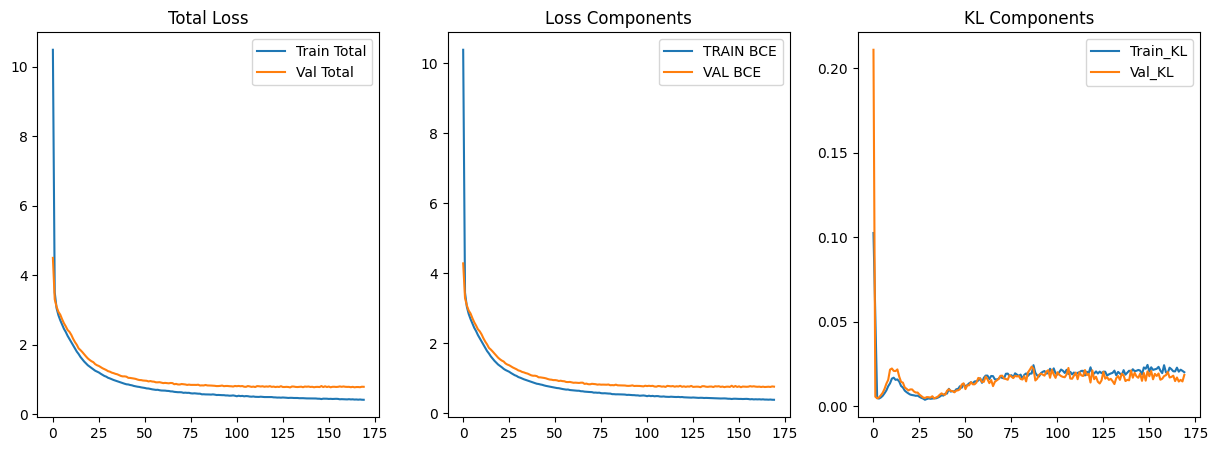

In [9]:
# 5. 결과 시각화
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Total')
plt.plot(history['val_loss'], label='Val Total')
plt.title('Total Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history['train_bce'], label='TRAIN BCE')
plt.plot(history['val_bce'], label='VAL BCE')
plt.title('Loss Components')
plt.legend()

plt.subplot(1,3,3)
plt.plot(history['train_kl'],label ='Train_KL')
plt.plot(history['val_kl'], label = 'Val_KL')
plt.title('KL Components')
plt.legend()
plt.show()

### test 계산

In [10]:
from bce_metrics.bce_solve import eval_bce_metrics

In [11]:
early_stopping.load_best_model(model)
model.eval()
all_x_hat = []
all_x_true = []
with torch.no_grad():
    for x_t,c_t in test_loader:
        x_t,c_t = x_t.to(device),c_t.to(device)
        t_bce_logit,t_prob_mask,t_binary_out,t_mu,t_logvar = model(x_t,c_t)
        x_true = (x_t>0).float()
        all_x_hat.append(t_bce_logit.detach().cpu())
        all_x_true.append(x_true.detach().cpu())
all_x_hat = torch.cat([a.flatten() for a in all_x_hat])
all_x_true = torch.cat([a.flatten() for a in all_x_true])

metrics = eval_bce_metrics(all_x_hat,all_x_true,threshold=0.5)
metrics
        

Restored best model with loss: 0.767305


{'threshold': 0.5,
 'bce': 0.02794736810028553,
 'tp': 1629,
 'fp': 90,
 'tn': 25288,
 'fn': 179,
 'precision': 0.9476439790520789,
 'recall': 0.9009955752162556,
 'f1': 0.9237312113291054,
 'accuracy': 0.9901052012061391}

In [12]:
import json

# metrics 결과 저장
save_path = "pre_re_condition_metrics.json"

with open(save_path, 'w') as f:
    json.dump(metrics, f, indent=4)

print(f"지표가 {save_path}에 저장되었습니다.")

지표가 pre_re_condition_metrics.json에 저장되었습니다.


In [13]:
x_true = all_x_true.reshape(-1,23)
x_hat = all_x_hat.reshape(-1,23)
x_true = torch.sigmoid(x_true[8])
x_tre = (x_true>0.5).float()
x_hat = torch.sigmoid(x_hat[8])
x_true = (x_true>0.5).float()
x_hat = (x_hat>0.5).float()
print(x_true,x_hat)

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]) tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.])
